In [1]:
import json

import dgl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import torch


sns.set_style('darkgrid')
plt.rcParams.update({
    'figure.figsize': (24, 12),
    'font.size': 18,
})

DATE_FORMAT = '%m/%d/%Y'

In [2]:
model_name = 'model-05-bce'

In [3]:
G = dgl.load_graphs('dgl_icews_graph.bin')[0][0]

In [5]:
icews = pd.read_csv('icews_redux.csv', header=0, index_col=['Event ID'], parse_dates=['Event Date'], date_format=DATE_FORMAT)
icews.drop(columns=['CAMEO Code', 'Story ID', 'Sentence Number', 'Latitude', 'Longitude'], inplace=True)
icews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950359 entries, 36615529 to 37764068
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event Date      950359 non-null  object 
 1   Source Name     950359 non-null  object 
 2   Source Sectors  686161 non-null  object 
 3   Source Country  909074 non-null  object 
 4   Source Type     950359 non-null  object 
 5   Event Text      950359 non-null  object 
 6   Intensity       950359 non-null  float64
 7   Target Name     950359 non-null  object 
 8   Target Sectors  577849 non-null  object 
 9   Target Country  907127 non-null  object 
 10  Target Type     950359 non-null  object 
 11  Publisher       950359 non-null  object 
 12  City            643528 non-null  object 
 13  District        151008 non-null  object 
 14  Province        711140 non-null  object 
 15  Country         950285 non-null  object 
dtypes: float64(1), object(15)
memory usage: 123.3+ MB


In [6]:
entity_countries = icews.groupby('Source Name')['Source Country'].nunique()

In [7]:
entity_countries[entity_countries != 1]

Source Name
Abbott Laboratories                0
Abdullatif Al-Zayani               0
Abdullatif bin Rashid Al-Zayani    0
Achim Steiner                      0
Activist (Greenpeace)              0
                                  ..
World Vision                       0
World Wildlife Fund                0
Wynn Resorts                       0
Zawahiri                           0
Zoran Zaev                         2
Name: Source Country, Length: 386, dtype: int64

In [8]:
ukraine_source = icews[(icews['Source Name'].str.contains('Ukraine')) | (icews['Source Country'] == 'Ukraine')]
ukraine_source.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53523 entries, 36615651 to 37763972
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Event Date      53523 non-null  object 
 1   Source Name     53523 non-null  object 
 2   Source Sectors  37027 non-null  object 
 3   Source Country  53523 non-null  object 
 4   Source Type     53523 non-null  object 
 5   Event Text      53523 non-null  object 
 6   Intensity       53523 non-null  float64
 7   Target Name     53523 non-null  object 
 8   Target Sectors  28091 non-null  object 
 9   Target Country  50379 non-null  object 
 10  Target Type     53523 non-null  object 
 11  Publisher       53523 non-null  object 
 12  City            34199 non-null  object 
 13  District        2864 non-null   object 
 14  Province        35604 non-null  object 
 15  Country         53523 non-null  object 
dtypes: float64(1), object(15)
memory usage: 6.9+ MB


In [9]:
ukraine_source.head()

,Event Date,Source Name,Source Sectors,Source Country,Source Type,Event Text,Intensity,Target Name,Target Sectors,Target Country,Target Type,Publisher,City,District,Province,Country
Event ID,,,,,,,,,,,,,,,,
36615651,2022-01-01,Reserve Personnel (Ukraine),"Government,Military",Ukraine,Other,"Arrest, detain, or charge with legal action",-5.0,Citizen (Ukraine),"General Population / Civilian / Social,Social",Ukraine,Organization,Unknown,Lviv,NaN,L'vivs'ka Oblast',Ukraine
36615720,2022-01-01,Volodymyr Zelensky,"Elite,Executive,Executive Office,Government",Ukraine,Name,Express intent to meet or negotiate,4.0,Joseph Robinette Biden,"(National) Major Party,Cabinet,Center Left,Exe...",United States,Name,BBC Monitoring Ukraine & Baltics,NaN,NaN,NaN,Ukraine
36615796,2022-01-01,Media Personnel (Ukraine),"Media,Social",Ukraine,Organization,Make statement,0.0,Russia,NaN,Russian Federation,Country,BBC Monitoring Ukraine & Baltics,NaN,NaN,NaN,Ukraine
36615832,2022-01-01,Ukraine,NaN,Ukraine,Country,Consult,1.0,United States,NaN,United States,Country,Unknown,NaN,NaN,NaN,Ukraine
36615840,2022-01-01,Volodymyr Zelensky,"Elite,Executive,Executive Office,Government",Ukraine,Name,"Impose embargo, boycott, or sanctions",-8.0,Company - Owner or Operator (Ukraine),"Business,Social",Ukraine,Other,BBC Monitoring Ukraine & Baltics,NaN,NaN,NaN,Ukraine


In [10]:
ukraine_source_entities = set(ukraine_source['Source Name'].str.strip().tolist())
print(len(ukraine_source_entities))

ukraine_source_targets = set(ukraine_source['Target Name'].str.strip().tolist())
print(len(ukraine_source_targets))

179
1462


In [11]:
ukraine_target = icews[(icews['Target Name'].str.contains('Ukraine')) | (icews['Target Country'] == 'Ukraine')]
ukraine_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82538 entries, 36615573 to 37764012
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Event Date      82538 non-null  object 
 1   Source Name     82538 non-null  object 
 2   Source Sectors  50363 non-null  object 
 3   Source Country  78572 non-null  object 
 4   Source Type     82538 non-null  object 
 5   Event Text      82538 non-null  object 
 6   Intensity       82538 non-null  float64
 7   Target Name     82538 non-null  object 
 8   Target Sectors  27319 non-null  object 
 9   Target Country  82538 non-null  object 
 10  Target Type     82538 non-null  object 
 11  Publisher       82538 non-null  object 
 12  City            53446 non-null  object 
 13  District        6057 non-null   object 
 14  Province        56285 non-null  object 
 15  Country         82538 non-null  object 
dtypes: float64(1), object(15)
memory usage: 10.7+ MB


In [12]:
ukraine_target.head()

,Event Date,Source Name,Source Sectors,Source Country,Source Type,Event Text,Intensity,Target Name,Target Sectors,Target Country,Target Type,Publisher,City,District,Province,Country
Event ID,,,,,,,,,,,,,,,,
36615573,2022-01-01,United States,NaN,United States,Country,Praise or endorse,3.4,Ukraine,NaN,Ukraine,Country,The New York Times,Kiev,NaN,Misto Kyyiv,Ukraine
36615574,2022-01-01,North Atlantic Treaty Organization,"Global,Global Defense / Security IGOs,Internat...",NaN,Organization,Praise or endorse,3.4,Ukraine,NaN,Ukraine,Country,The New York Times,Kiev,NaN,Misto Kyyiv,Ukraine
36615576,2022-01-01,Russia,NaN,Russian Federation,Country,Threaten,-4.4,Ukraine,NaN,Ukraine,Country,The New York Times,Moscow Kremlin,NaN,Moskovskaya Oblast',Russian Federation
36615591,2022-01-01,Russia,NaN,Russian Federation,Country,Use conventional military force,-10.0,Ukraine,NaN,Ukraine,Country,Unknown,NaN,NaN,Washington D.C.,United States
36615592,2022-01-01,Russia,NaN,Russian Federation,Country,Use conventional military force,-10.0,Ukraine,NaN,Ukraine,Country,Unknown,NaN,NaN,Washington D.C.,United States


In [13]:
ukraine_target_entities = set(ukraine_target['Target Name'].str.strip().tolist())
print(len(ukraine_source_entities))

ukraine_target_sources = set(ukraine_target['Source Name'].str.strip().tolist())
print(len(ukraine_target_sources))

179
1859


In [14]:
with open('entity_map.json') as f:
    entity_map = json.load(f)

In [15]:
ukraine_entity_index = entity_map['Ukraine']
print(ukraine_entity_index)

11386


In [16]:
ukraine_entities = ukraine_source_entities | ukraine_target_entities

ukraine_indices = torch.tensor([
    entity_map[e] for e in ukraine_entities
])

In [17]:
embeds = torch.load(f'embeds/{model_name}/embeds.pt')
attn = torch.load(f'embeds/{model_name}/attn.pt')

In [18]:
ukraine_embeds = embeds[ukraine_indices]
ukraine_embeds.shape

torch.Size([179, 128])

In [19]:
ukraine_attn = attn[ukraine_entity_index]
ukraine_attn.shape

torch.Size([220])

In [20]:
relations = G.etypes

In [21]:
ukraine_relation_attn = pd.DataFrame(zip(relations, ukraine_attn.tolist()), columns=['relation', 'attn'])
ukraine_relation_attn.sort_values('attn', ascending=False, inplace=True)

In [22]:
ukraine_relation_attn.head(25)

,relation,attn
77,Demand rights,0.066453
136,Impose curfew,0.051969
190,"Reject request for change in institutions, regime",0.049095
171,Receive inspectors,0.045024
33,Appeal for rights,0.037542
75,Demand political reform,0.031536
157,Obstruct passage to demand leadership change,0.029529
76,Demand release of persons or property,0.028720
144,Investigate human rights abuses,0.028259
67,Demand humanitarian aid,0.027348


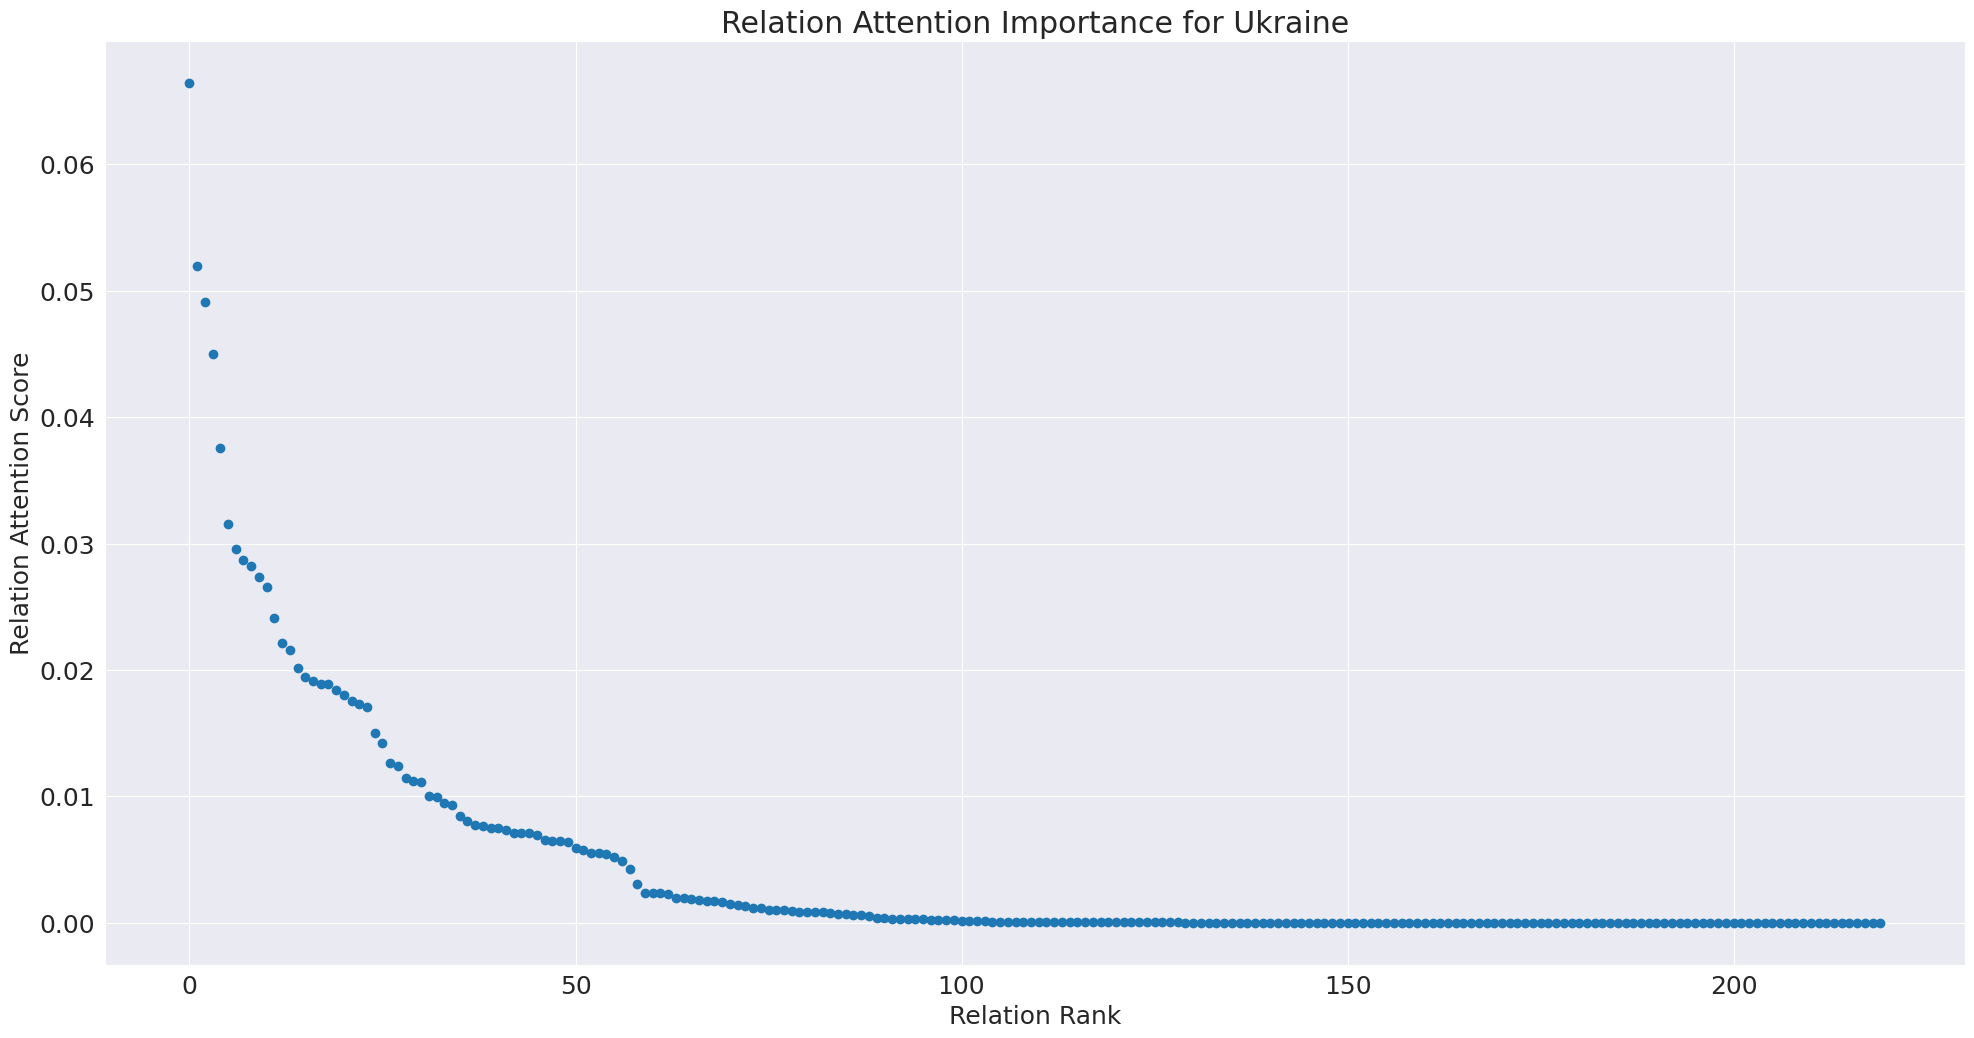

In [36]:
plt.scatter(x=range(len(ukraine_attn)), y=sorted(ukraine_attn.tolist(), reverse=True))
plt.xlabel('Relation Rank')
plt.ylabel('Relation Attention Score')
plt.title('Relation Attention Importance for Ukraine')
plt.show()

---

In [31]:
tsne = TSNE(verbose=2, perplexity=50, n_iter=2500)

In [32]:
tsne_embeds = tsne.fit_transform(embeds)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11814 samples in 0.002s...
[t-SNE] Computed neighbors for 11814 samples in 0.769s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11814
[t-SNE] Computed conditional probabilities for sample 2000 / 11814
[t-SNE] Computed conditional probabilities for sample 3000 / 11814
[t-SNE] Computed conditional probabilities for sample 4000 / 11814
[t-SNE] Computed conditional probabilities for sample 5000 / 11814
[t-SNE] Computed conditional probabilities for sample 6000 / 11814
[t-SNE] Computed conditional probabilities for sample 7000 / 11814
[t-SNE] Computed conditional probabilities for sample 8000 / 11814
[t-SNE] Computed conditional probabilities for sample 9000 / 11814
[t-SNE] Computed conditional probabilities for sample 10000 / 11814
[t-SNE] Computed conditional probabilities for sample 11000 / 11814
[t-SNE] Computed conditional probabilities for sample 11814 / 11814
[t-SNE] Mean sigma: 0.311435
[t-SNE] Computed con

In [33]:
entities = sorted(entity_map, key=lambda x: entity_map[x])

In [34]:
tsne_data = pd.DataFrame(zip(entities, tsne_embeds[:, 0], tsne_embeds[:, 1]), columns=['entity', 'component0', 'component1'])

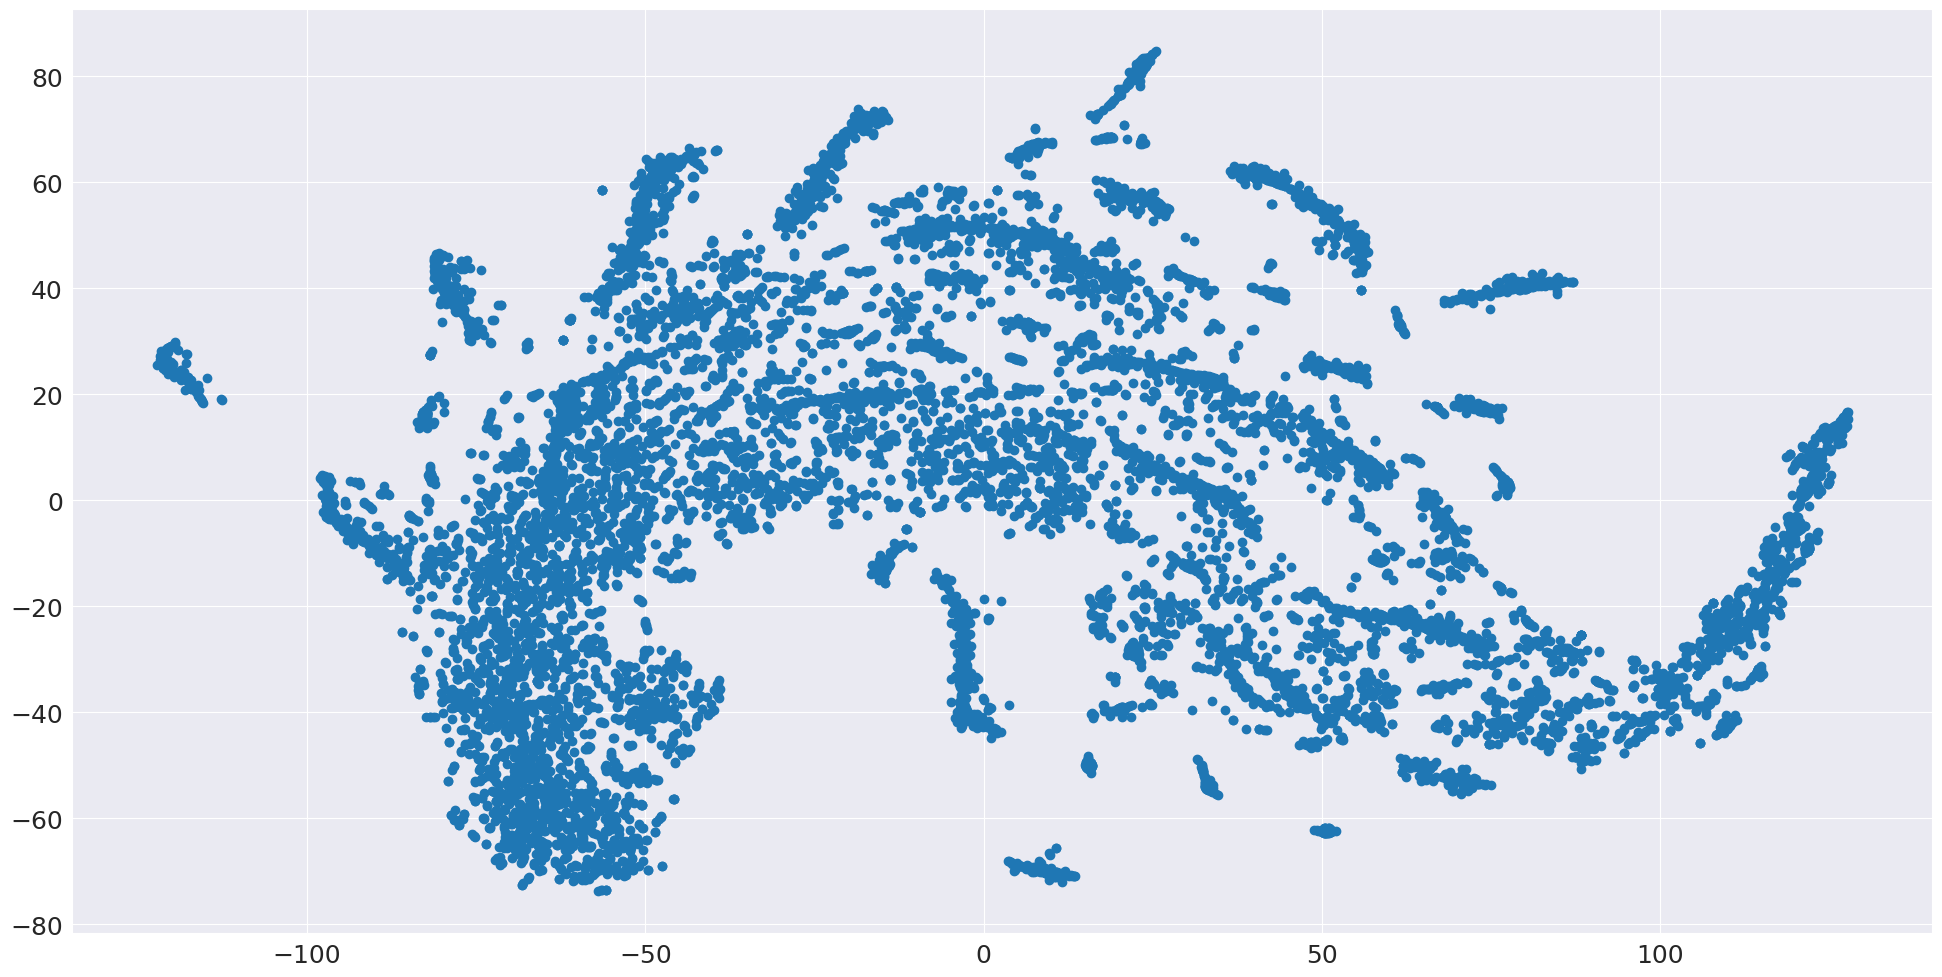

In [35]:
plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1])
plt.show()